In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import os
import shutil
import zipfile
from PIL import Image, ImageDraw

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

import warnings
warnings.filterwarnings('ignore')


Using TensorFlow backend.


In [3]:
class CustomDataset(utils.Dataset):
    #like data format from https://datature.io/intellibrush or makesense.com
    #export coco polygons / masks format
    #two file annotations train and validation
    def load_custom(self, annotation_json, images_dir, dataset_type="train"):
        #load annotation
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        #multiple class
        #không cần thiết lập class, class được thiết lập động theo file annotation
        #id của class không được bằng 0, bởi vì mặc định class background = 0, không cần khai báo thêm class background
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(
                    class_name))
                return

            self.add_class(source_name, class_id, class_name)

        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)

        # Get all images and add them to the dataset
        seen_images = {}

        # Split the dataset, if train, get 90%, else 10%
        len_images = len(coco_json['images'])
        if dataset_type == "train":
            img_range = [int(len_images / 9), len_images]
        else:
            img_range = [0, int(len_images / 9)]

        for i in range(img_range[0], img_range[1]):
            image = coco_json['images'][i]
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))

                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]

                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )

    def load_mask(self, image_id):

        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        return mask, class_ids

    def count_classes(self):
        class_ids = set()
        for image_id in self.image_ids:
            image_info = self.image_info[image_id]
            annotations = image_info['annotations']

            for annotation in annotations:
                class_id = annotation['category_id']
                class_ids.add(class_id)

        class_number = len(class_ids)
        return class_number


In [4]:
def display_image_samples(dataset_train):
    # Load and display random samples
    image_ids = np.random.choice(dataset_train.image_ids, 4)

    for image_id in image_ids:
        image = dataset_train.load_image(image_id)
        mask, class_ids = dataset_train.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

def load_image_dataset(annotation_path, dataset_path, dataset_type):
    dataset_train = CustomDataset()
    dataset_train.load_custom(annotation_path, dataset_path, dataset_type)
    dataset_train.prepare()
    return dataset_train

In [5]:
annotation_path = r'C:\Users\HPDQ\Mask_RCNN\DATASET\data-count-bar\train.json'
dataset_path = r'C:\Users\HPDQ\Mask_RCNN\DATASET\data-count-bar\image'
dataset_type = "train"
annotation_path = r'C:\Users\HPDQ\Mask_RCNN\DATASET\data-count-bar\validate.json'
dataset_path = r'C:\Users\HPDQ\Mask_RCNN\DATASET\data-count-bar\image'
dataset_type = "val"

In [6]:
dataset_train = load_image_dataset(annotation_path, dataset_path, "train")
dataset_val = load_image_dataset(annotation_path, dataset_path, "train")

In [7]:
print(len(dataset_train.image_ids))
print(len(dataset_val.image_ids))

3
3


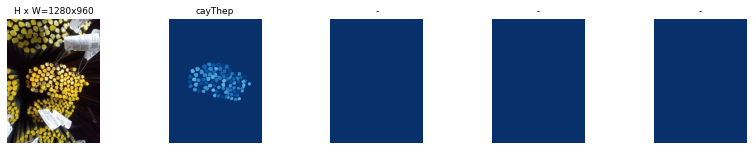

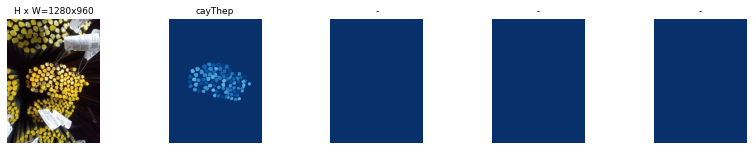

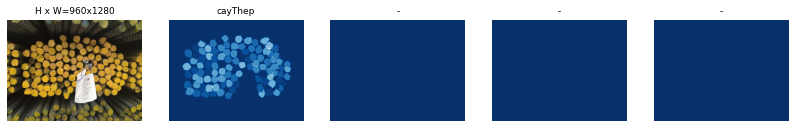

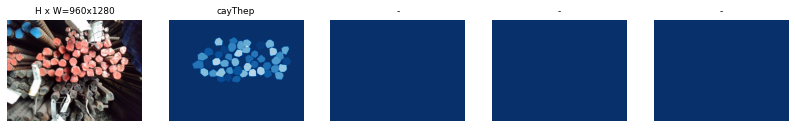

In [8]:
display_image_samples(dataset_train)

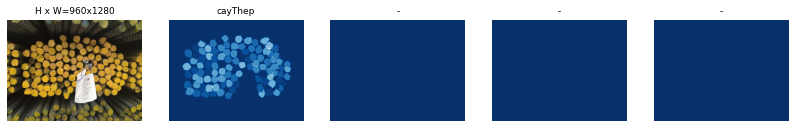

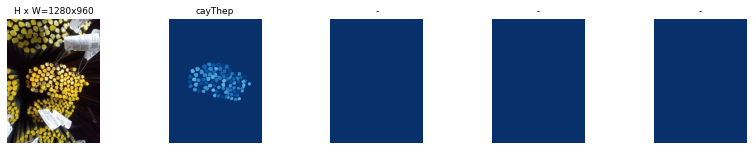

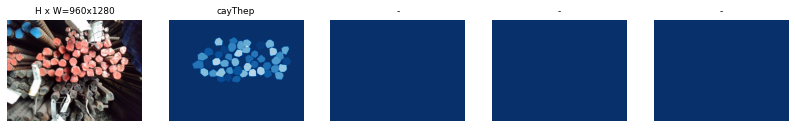

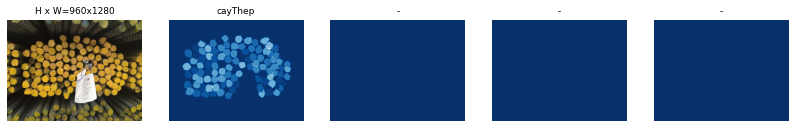

In [9]:
display_image_samples(dataset_val)

In [14]:
class SteelConfig(Config):

    NAME = "steel"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = 2 + 1  # background + 4 defect classes

    IMAGE_MIN_DIM = 960
    IMAGE_MAX_DIM = 960

    EPOCHS = 50
    
    # Steps per epoch
    STEPS_PER_EPOCH = 1000

    # validation steps per epoch
    VALIDATION_STEPS = 50
    
config = SteelConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EPOCHS                         50
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  960
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  960
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [960 960   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE         

In [15]:
MODEL_DIR = 'logs'
import mrcnn.model as modellib

In [16]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
COCO_MODEL_PATH = r"C:\Users\HPDQ\Mask_RCNN\mask_rcnn_coco.h5"
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
# Required due to change in new Tensorflow / Keras version
model.keras_model.metrics_tensors = []

In [ ]:
print("Training")
model.train(dataset_train, 
            dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=config.EPOCHS,            
            layers='all')

Training

Starting at epoch 0. LR=0.001

Checkpoint Path: logs\steel20211123T2034\mask_rcnn_steel_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (B